In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
import sys
import GAE
from pathlib import Path
import torch.nn.functional as F

In [3]:
use_cuda = True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_compare(img1, img2):
    #innormalize
    img1 = img1 / 2 + 0.5
    img2 = img2 / 2 + 0.5
    
    #to_numpy
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(np.transpose(npimg1, (1, 2, 0)))
    axarr[1].imshow(np.transpose(npimg2, (1, 2, 0)))

    plt.show()

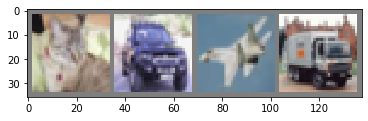

  cat   car plane truck


In [6]:
# get some random training images
dataiter = iter(testloader)
dataiter.next()
dataiter.next()
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
def plotConfidence(TrueConf, AdvConf):
    # data to plot
    n_groups = 10
    Actual = TrueConf.cpu().numpy()
    Adversarial = AdvConf.cpu().numpy()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, Actual, bar_width,
    alpha=opacity,
    color='g',
    label='Actual')

    rects2 = plt.bar(index + bar_width, Adversarial, bar_width,
    alpha=opacity,
    color='r',
    label='Adversarial')

    plt.xlabel('Class')
    plt.ylabel('Confidence')
    plt.title('Confidence of Examples by Model')
    plt.xticks(index + bar_width, classes)
    plt.legend()

    plt.tight_layout()
    plt.show()

def show_conf(actual_pred, fgsm_pred, or_image, per_image):
    actual = torch.sigmoid(actual_pred)*100
    fgsm = torch.sigmoid(fgsm_pred)*100
    imshow_compare(or_image, per_image)
    plotConfidence(actual, fgsm)

def show(i):
    show_conf(original_output[i], perturbed_output[i], images[i], perturbed_image[i])

In [12]:
from GAE.model import Net
model = GAE.model1()
original_output, perturbed_output, perturbed_image = GAE.GenAdv(model, images, 0.1, labels, torch.device('cpu'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


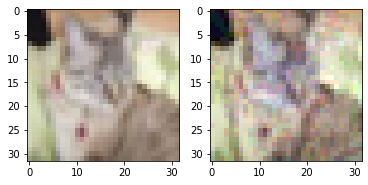

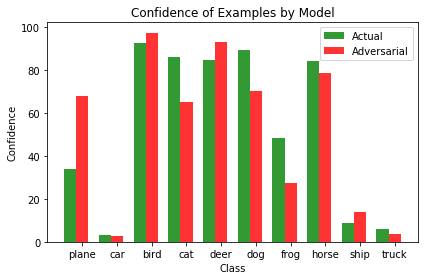

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


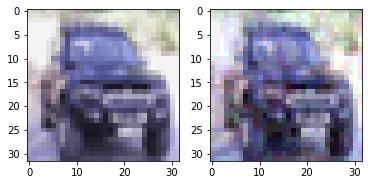

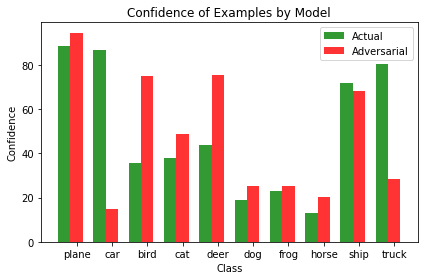

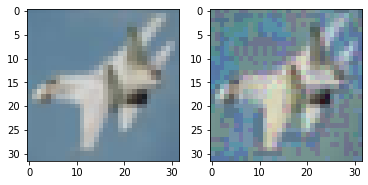

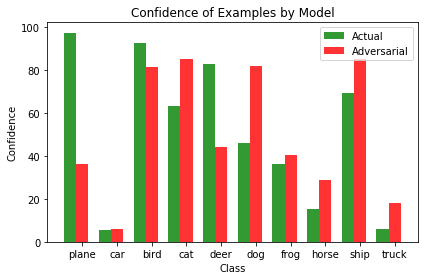

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


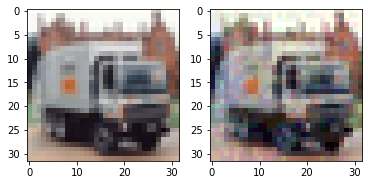

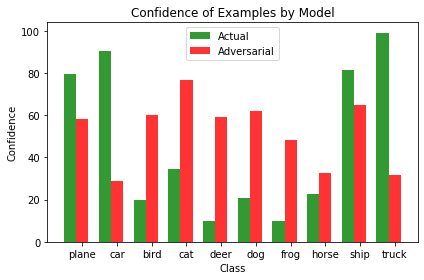

In [13]:
for i in range(images.shape[0]):
    show(i)

In [10]:
#Using Resnet32 pretrained Model
epsilon = 0.01
resnet32 = GAE.pre_resnet32()
original_output, perturbed_output, perturbed_image = GAE.GenAdv(resnet32, images, epsilon, labels, device)

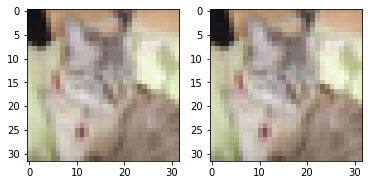

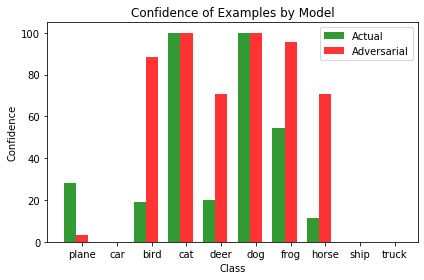

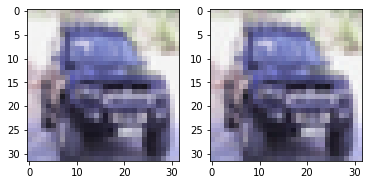

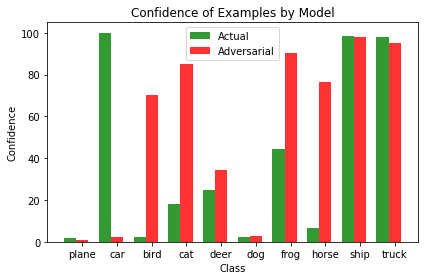

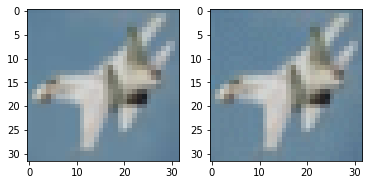

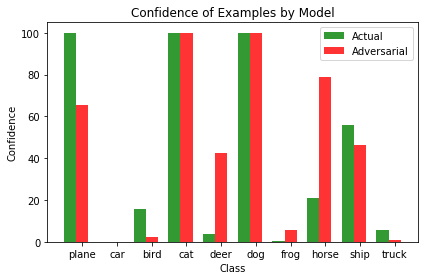

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


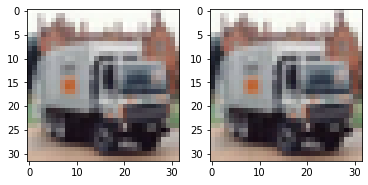

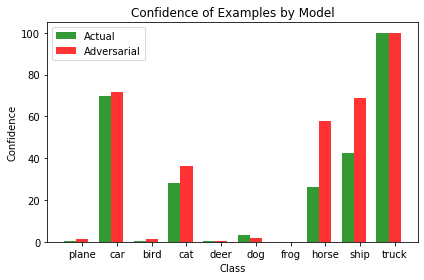

In [11]:
for i in range(images.shape[0]):
    show(i)

In [10]:
labels.shape

torch.Size([4])

In [11]:
def cw_l2(model, image, target, c=1e-2, bin_search_steps=5, max_iter=10, const_upper=1, learning_rate=0.1, device=torch.device('cpu')):
    """Carlini Wagner l2 https://arxiv.org/abs/1608.04644"""
    image, target = image.to(device), target.to(device)
    model = model.to(device)
    original_output = model(image)
    _, out_label = torch.max(original_output, 1)
    w = torch.empty(image.shape).uniform_()
    w.requires_grad_()
    optimizer = torch.optim.SGD([w], lr=learning_rate)
    target_one_hot = torch.zeros(output.shape[1])
    target_one_hot[target] = 1.
    target_one_hot.requires_grad=True
    const_lower = 0
    const_upper = const_upper
    adv_image = image+torch.tanh(w).add_(1)/2
    
    for i in range(bin_search_steps):
        optimizer.zero_grad()
        output = model(adv_image)
        real = torch.sum(target*output[0])
        other = torch.sum(torch.max((1.-target)*output[0]-target*10000))
        loss = c*torch.max((other - real),-K) + torch.sum((adv_image-image)**2) #or torch.sum(torch.abs(r))
        loss.backward()
        optimizer.step()
        adv_image = image+torch.tanh(w).add_(1)/2
        delta = (adv_image-image).clone().detach().requires_grad_(False)
        _, out_label = torch.max(model(adv_image), 1)
        if(torch.sum(delta**2).item()<torch.sum(delta_old**2).item() and target.item()==out_label.item()):
            delta_old = delta.clone().detach().requires_grad_(False)
        if(target.item()==out_label.item()):
            const_upper = min(const_upper, c)
            c = (const_upper+const_lower)/2
        else:
            const_lower = max(const_lower, c)
            c = (const_upper+const_lower)/2
    w.requires_grad = False    
    perturbed_output = model(adv_image)
    perturbed_image = adv_image
    original_output, perturbed_output = original_output.detach(), perturbed_output.detach()
    return original_output, perturbed_output, perturbed_image.detach()

In [9]:
original_output, perturbed_output, perturbed_image.detach = cw_l2(model, image, target, c=1e-2, bin_search_steps=5, max_iter=10, const_upper=1, learning_rate=0.1, device=torch.device('cpu'))

tensor(2)